# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists_lin_feat_df_withoutuserfeat_allcomments.pkl")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 103888 entries, body to mrc_pmean
dtypes: float64(87790), int64(16092), object(6)
memory usage: 1.2+ GB


In [3]:
# predictors = df.columns.tolist()
# i = 0
# predictorsfile=open('predictorslist.txt','w')
# # predictorsfile.writelines(predictors)
# for element in predictors:
#     predictorsfile.write(str(i))
#     predictorsfile.write(" ")
#     predictorsfile.write(element)
#     predictorsfile.write('\n')
#     i+=1
# predictorsfile.close()

In [4]:
# multilevel columns

lst1 = (5)*["data"]
lst9 = (15-5)*["traits"]
lst10 = ["data"]
lst2 = (21-17)*["global"]
lst3 = (45-21)*["time"]
lst4 = (16103-45)*["subreddits"]
lst5 = (16116-16103)*["extra_features"]
lst6 = (96308-16116)*["word_ngrams"]
lst7 = (103829-96308)*["char_ngrams"]
lst8 = (103889-103829)*["wordlists"]
headers = lst1 + lst9  + lst10 + lst2 + lst3 + lst4 +lst5 + lst6 + lst7 + lst8 
columns = df.columns.values
print(len(headers))
print(len(columns))
arrays = [headers] + [columns]
df.columns=pd.MultiIndex.from_arrays(arrays)
print(df.columns)

103888
103888
MultiIndex([(     'data',              'body'),
            (     'data',          'doc_body'),
            (     'data',           'probody'),
            (     'data',            'tokens'),
            (     'data',        'senttokens'),
            (   'traits',     'agreeableness'),
            (   'traits',          'openness'),
            (   'traits', 'conscientiousness'),
            (   'traits',      'extraversion'),
            (   'traits',       'neuroticism'),
            ...
            ('wordlists',               'CNC'),
            ('wordlists',               'IMG'),
            ('wordlists',               'FAM'),
            ('wordlists',               'SER'),
            ('wordlists',           'valence'),
            ('wordlists',         'dominance'),
            ('wordlists',         'negations'),
            ('wordlists',          'articles'),
            ('wordlists',         'mrc_cmean'),
            ('wordlists',         'mrc_pmean')],
         

In [5]:
test = df.columns

print(test[40:50])

MultiIndex([(      'time',              '2016'),
            (      'time',              '2017'),
            (      'time',              '2018'),
            (      'time',              '2019'),
            ('subreddits',         'vikingstv'),
            ('subreddits', 'gotwinteriscoming'),
            ('subreddits',           'singing'),
            ('subreddits',          'blink182'),
            ('subreddits',             'moxun'),
            ('subreddits',        'blockchain')],
           )


In [6]:
df['traits', 'agree5'] = df['traits', 'agreeableness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'openn5'] = df['traits', 'openness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'consc5'] = df['traits', 'conscientiousness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'extra5'] = df['traits', 'extraversion'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'neuro5'] = df['traits', 'neuroticism'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))

In [7]:
smalldf = df[['traits', 'global', 'time', 'extra_features', 'word_ngrams', 'char_ngrams', 'wordlists']]
smalldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 87829 entries, ('traits', 'agreeableness') to ('wordlists', 'mrc_pmean')
dtypes: float64(87788), int64(41)
memory usage: 1.1+ GB


In [8]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['traits', 'agreeableness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['traits', 'openness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['traits', 'conscientiousness'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['traits', 'extraversion'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['traits', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()


## Trait

In [9]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'traits'], axis=1, level=0)
#     df.drop('traits', axis=1)
#     featuredf = df[['global', 'time', 'subreddits', 'extra_features', 'word_ngrams', 'char_ngrams', 'wordlists']]
#     featuredf = df.loc[:, df.columns != ['data', 'traits']]
#     featuredf = df.loc[:, df.columns != 'data']
#     featuredf = featuredf.loc[:, featuredf.columns != 'traits']
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
    
        if trait_name == 'agreeableness':
            y = df['traits', 'agree']
        elif trait_name == 'openness':
            y = df['traits', 'openn']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro']   
    else:
        if trait_name == 'agreeableness':
            y = df['traits', 'agree5']
        elif trait_name == 'openness':
            y = df['traits', 'openn5']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc5']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra5']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro5'] 
            
    
    return x,y 

## Classifier

1. Logistic regression

In [10]:
def logclassifier(x_train,y_train, x_test):
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
#     y_pred=logreg.predict(x_test)    
    return logreg

# logreg = logclassifier(x_train,y_train, x_test)
# y_pred=logreg.predict(x_test)



# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train, classifier, num_feat):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('scaler', StandardScaler()),
          ('classification', LogisticRegression(class_weight='balanced' ,n_jobs=-1))
        ])
    elif classifier == "multilog":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('scaler', StandardScaler()),
          ('classification', LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='liblinear', n_jobs=-1))
        ])
        
    pipeline.fit(x_train, y_train)
    return pipeline





# logpipe = create_pipeline('log')
# y_pred=logpipe.predict(x_test)

# print("shape of x before feature selection", x.shape)
# x_new = SelectKBest(f_classif, k=30).fit_transform(x, y)
# print("shape of x after feature selection", x_new.shape)

## Get names of 30 most important features

In [11]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names
# names = get_names(logpipe)
# print(names)

### Get p-values

In [12]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [13]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [14]:
def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix)
#     disp.plot() 
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sumpositive = tp + fn
    sumnegative = fp + tn
    sumcorrect = tp + tn
    sumwrong = fp + fn
    sumall = tn+fp+fn+tp
    print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
          sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
          sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
          "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("bottom")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

# Wrapper

In [15]:
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

def switching(trait):
    switcher={
            'openness':30,
            'conscientiousness':30,
            'agreeableness':30,
            'extraversion':30,
            'neuroticism':30
         }
    return switcher.get(trait,"Invalid")

def classify(df, classes, plotting=True):
    for trait_name in traits:
        num_feat = switching(trait_name)
        print("Trait to predict: ", trait_name)
        if classes == 'binary':
            x,y = trait(df, 'binary',trait_name)
        else:
            x,y = trait(df, 'multi', trait_name)  
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        print("Number of authors in y_train: ", len(y_train))
        print("Number of authors in y_test: ", len(y_test))
        logpipe = create_pipeline(x_train, y_train, 'log', num_feat)
        y_pred=logpipe.predict(x_test)
        print("Number of authors in y_pred: ", len(y_pred))
        names = get_names(x, logpipe)
        print("Names of the top", len(names), "features: \n", names, "\n")
        pvalues = get_pvalues(logpipe, x)
    #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
        if trait_name=="openness":
            count = pvalues['pvalue'].le(0.02).sum()
        if trait_name=="conscientiousness":
            count = pvalues['pvalue'].le(0.07).sum()
        if trait_name=="extraversion":
            count = pvalues['pvalue'].le(0.05).sum()
        if trait_name=="agreeableness":
            count = pvalues['pvalue'].le(0.04).sum()
        if trait_name=="neuroticism":
            count = pvalues['pvalue'].le(0.04).sum()
        print("Number of features with this threshold: ", count)
#         print("\nP-Values: \nNumber of features: ", 30)
#         print(pvalues.nsmallest(count,'pvalue'))
        print("\n")
        report = scores(y_test, y_pred, "report")
        print("Classification report: \n", report)
        if classes == 'binary':
            cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True) 
    #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
    #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
            lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

# startnumber ngrams : 36
# startnumber wordlists: 29
# startnumber: linguistic features: 30
# startnumber: authorversion with arrays in user features: 26
# startnumber: final version 18
# start = 18

## Histogram of true traits

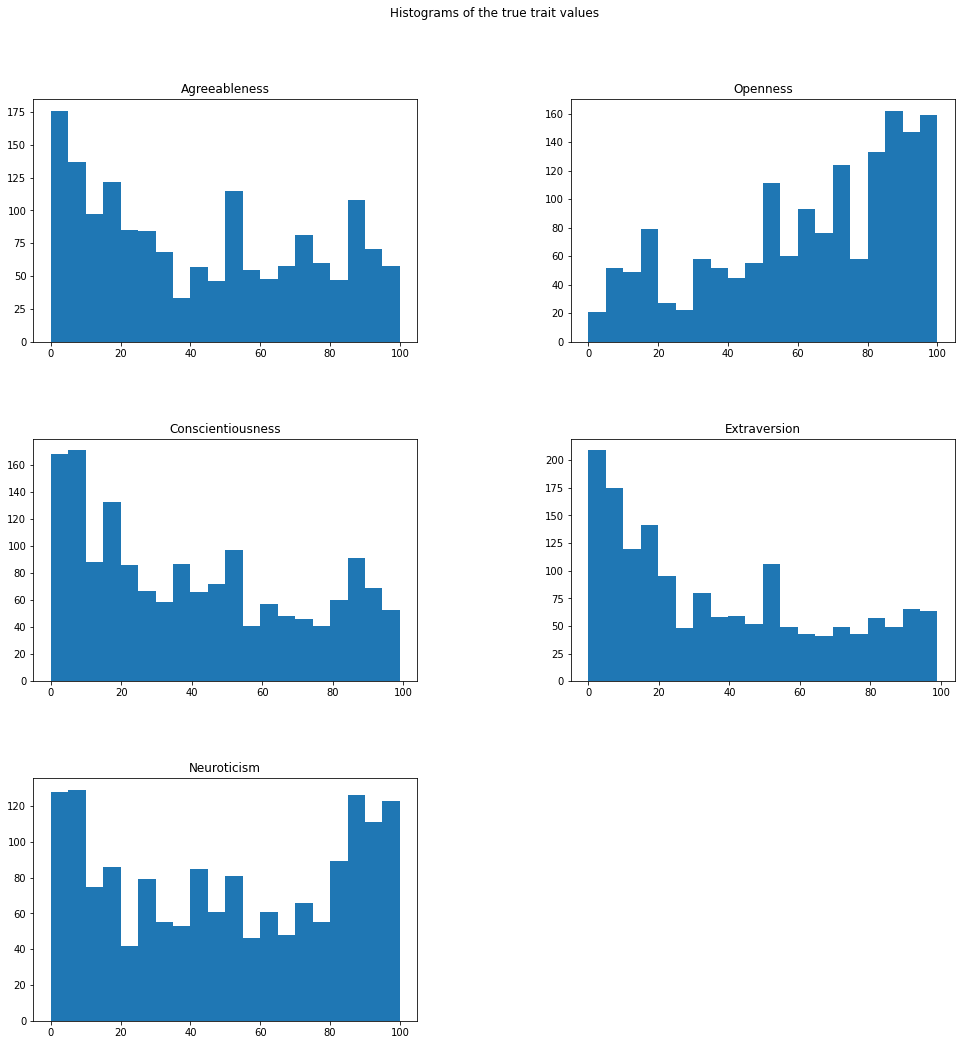

In [16]:
# true histogram plots
all_hist_true(df)

In [17]:
# %%javascript
# IPython.OutputArea.auto_scroll_threshold = 1000;

## Test set: binary outcome

Y is binary: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',      'taylorswiftbum'),
            ('subreddits',        'colonizemars'),
            ('subreddits',  'takeonestepforward'),
            ('subreddits',      'incelsgonewild'),
            ('subreddits',           'xsomalian'),
            ('subreddits',     'choose_your_own'),
            ('subreddits',            'calmdown'),
            ('subreddits',         'pharahmains'),
            ('subreddits',            'polyglot'),
            ('subreddits',             'scratch'),
            ('subreddits',              'techno'),
            ('subreddits',       'manyatruenerd'),
            ('subreddits',       'youshouldknow'),
            ('subreddits',          'pussymound'),
            ('subreddits',         'pipetobacco'),
            ('subreddits',    'perfect_response'),
            ('subreddits',                 'npc'),
            ('subreddits',            'winnipeg'),
            ('su

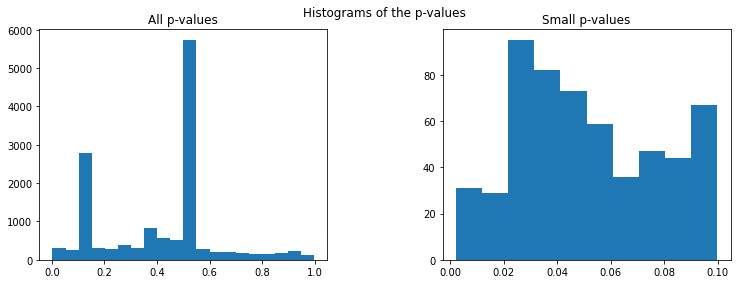

Number of features with this threshold:  54


Classification report: 
               precision    recall  f1-score   support

           0       0.40      0.15      0.22       105
           1       0.75      0.92      0.83       297

    accuracy                           0.72       402
   macro avg       0.58      0.54      0.52       402
weighted avg       0.66      0.72      0.67       402

TN, FP, FN, TP:  16 89 24 273 
Sum:  402 
Sum correct predictions:  289 Percent:  0.7189054726368159 
Sum wrong predictions:  113 	Percent:  0.2810945273631841 
Sum actual positives:  297 	Percent:  0.7388059701492538 
Sum actual negatives:  105 	Percent:  0.26119402985074625


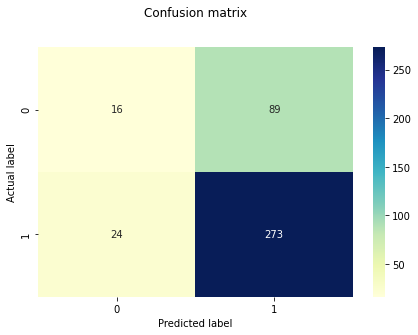

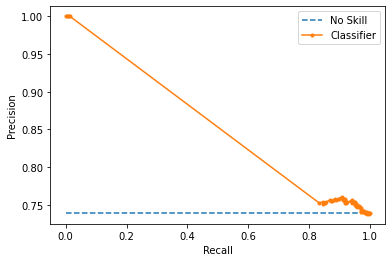

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(      'time',           'friday'),
            (      'time',            'march'),
            (      'time',             'june'),
            (      'time',         'november'),
            (      'time',             '2017'),
            ('subreddits',         'cyberdom'),
            ('subreddits',  'tuckedinkitties'),
            ('subreddits',             'anno'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',              'tfc'),
            ('subreddits',      'bimbofetish'),
            ('subreddits',            'ecchi'),
            ('subreddits',         'roadporn'),
            ('subreddits',        'roastmeta'),
            ('subreddits',       'kansascity'),
            ('subreddits',   'warframerunway'),
            ('subreddits',             'nova'),
            ('subreddits',     'allthingsmlg'),
            ('subreddits',       'floridaman'),
            ('subreddi

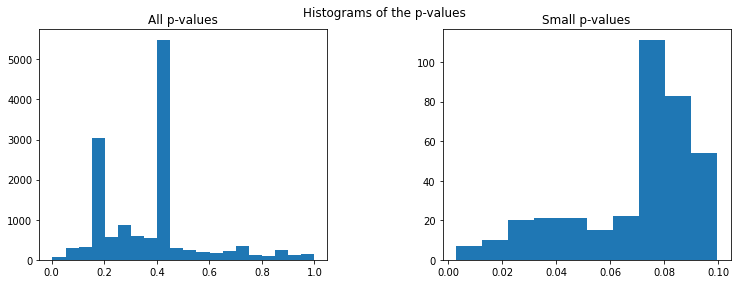

Number of features with this threshold:  115


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.67      0.66       251
           1       0.42      0.40      0.41       151

    accuracy                           0.56       402
   macro avg       0.53      0.53      0.53       402
weighted avg       0.56      0.56      0.56       402

TN, FP, FN, TP:  167 84 91 60 
Sum:  402 
Sum correct predictions:  227 Percent:  0.5646766169154229 
Sum wrong predictions:  175 	Percent:  0.43532338308457713 
Sum actual positives:  151 	Percent:  0.3756218905472637 
Sum actual negatives:  251 	Percent:  0.6243781094527363


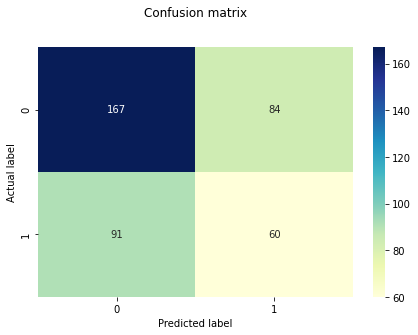

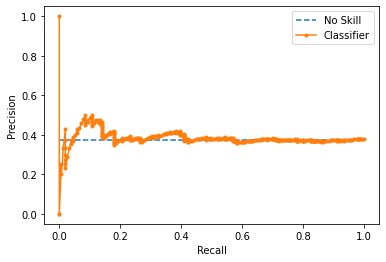

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',             'aram'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',      'politicsnow'),
            ('subreddits',      'goldenkamuy'),
            ('subreddits',  'theexaminedlife'),
            ('subreddits',      '300yearsago'),
            ('subreddits',          'newgirl'),
            ('subreddits',        'stretched'),
            ('subreddits',      'learncsharp'),
            ('subreddits',        'studioone'),
            ('subreddits',        'pokememes'),
            ('subreddits',         'birthday'),
            ('subreddits',   'bigtiddygothgf'),
            ('subreddits',             'mepl'),
            ('subreddits',     'christianr4r'),
            ('subreddits',      'ridiebridie'),
            ('subreddits',          'ableton'),
            ('subreddits',  'oopsdidntmeanto'),
            ('subreddits',            'motog'),
            ('subreddi

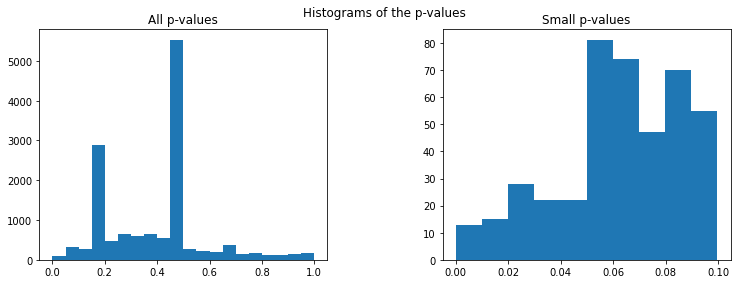

Number of features with this threshold:  101


Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.87      0.76       258
           1       0.48      0.22      0.30       144

    accuracy                           0.64       402
   macro avg       0.58      0.54      0.53       402
weighted avg       0.60      0.64      0.59       402

TN, FP, FN, TP:  225 33 113 31 
Sum:  402 
Sum correct predictions:  256 Percent:  0.6368159203980099 
Sum wrong predictions:  146 	Percent:  0.36318407960199006 
Sum actual positives:  144 	Percent:  0.3582089552238806 
Sum actual negatives:  258 	Percent:  0.6417910447761194


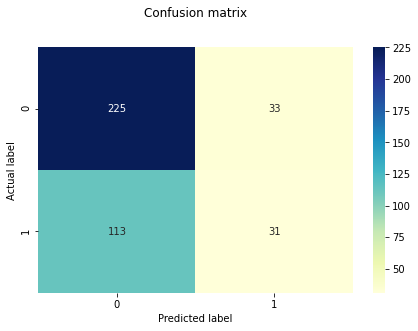

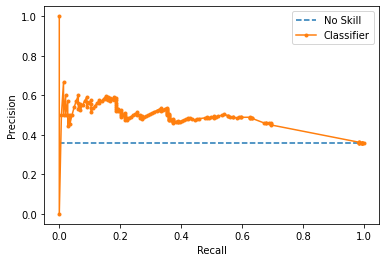

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(    'global',    'controversiality'),
            ('subreddits',                'aram'),
            ('subreddits',        'xntxpolitics'),
            ('subreddits',      'cursedcomments'),
            ('subreddits',       'healthanxiety'),
            ('subreddits',          'brainmemes'),
            ('subreddits',   'legendsoftomorrow'),
            ('subreddits',     'hmusfederalists'),
            ('subreddits',     'mhoclabourpress'),
            ('subreddits',                 'jhu'),
            ('subreddits',        'donaldglover'),
            ('subreddits',           'berlindnd'),
            ('subreddits',                'meup'),
            ('subreddits',     'notthebeaverton'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',                'cern'),
            ('subreddits',            'celebsbr'),
            ('subreddits',                'beer'),
            ('su

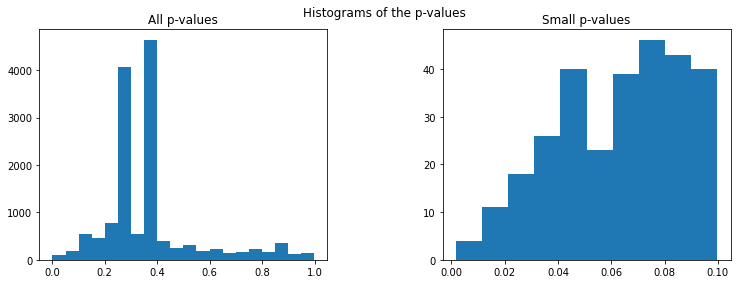

Number of features with this threshold:  53


Classification report: 
               precision    recall  f1-score   support

           0       0.61      0.65      0.63       225
           1       0.52      0.47      0.50       177

    accuracy                           0.57       402
   macro avg       0.57      0.56      0.56       402
weighted avg       0.57      0.57      0.57       402

TN, FP, FN, TP:  147 78 93 84 
Sum:  402 
Sum correct predictions:  231 Percent:  0.5746268656716418 
Sum wrong predictions:  171 	Percent:  0.4253731343283582 
Sum actual positives:  177 	Percent:  0.44029850746268656 
Sum actual negatives:  225 	Percent:  0.5597014925373134


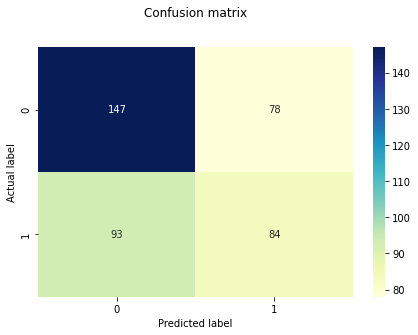

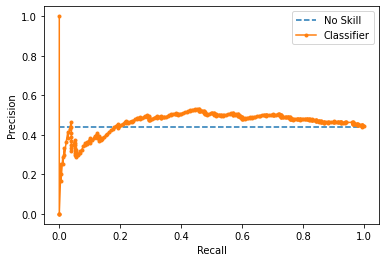

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',             'hammer'),
            ('subreddits',     'onetruetohsaka'),
            ('subreddits',        'rightwinguk'),
            ('subreddits', 'smallpenisproblems'),
            ('subreddits',               '5htp'),
            ('subreddits',            'actuary'),
            ('subreddits',                'g59'),
            ('subreddits',                'dae'),
            ('subreddits',          'intpmusic'),
            ('subreddits',                'm43'),
            ('subreddits',       'thegoodplace'),
            ('subreddits',                'gog'),
            ('subreddits',         'amumumains'),
            ('subreddits',    'mammothmountain'),
            ('subreddits',                'dsp'),
            ('subreddits',            'riseupp'),
            ('subreddits',              'bacon'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',        

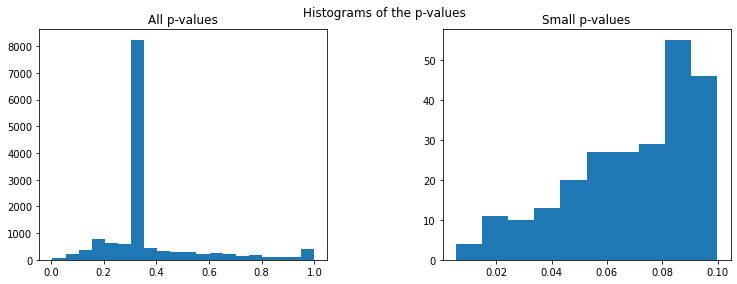

Number of features with this threshold:  31


Classification report: 
               precision    recall  f1-score   support

           0       0.51      0.63      0.56       201
           1       0.52      0.40      0.45       201

    accuracy                           0.51       402
   macro avg       0.52      0.51      0.51       402
weighted avg       0.52      0.51      0.51       402

TN, FP, FN, TP:  126 75 120 81 
Sum:  402 
Sum correct predictions:  207 Percent:  0.5149253731343284 
Sum wrong predictions:  195 	Percent:  0.48507462686567165 
Sum actual positives:  201 	Percent:  0.5 
Sum actual negatives:  201 	Percent:  0.5


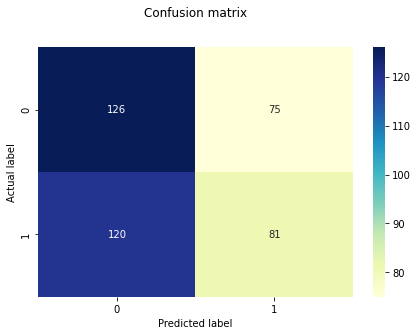

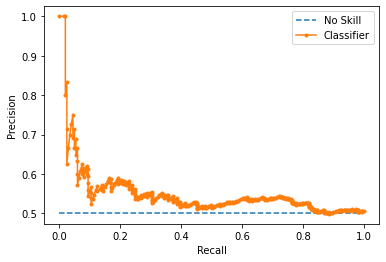

In [18]:
print("Y is binary: \n")
classify(df, 'binary', plotting=True)

## Test set: outcome has 5 classes

Y has 5 classes: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',     'taylorswiftbum'),
            ('subreddits', 'takeonestepforward'),
            ('subreddits',           'carlisle'),
            ('subreddits',     'incelsgonewild'),
            ('subreddits',            'effexor'),
            ('subreddits',            'dessert'),
            ('subreddits', 'swiggityswootygifs'),
            ('subreddits',           'calmdown'),
            ('subreddits',        'kutreclames'),
            ('subreddits',            'scratch'),
            ('subreddits',          'zeldabotw'),
            ('subreddits', 'foundthemobileuser'),
            ('subreddits',          'fuckdruid'),
            ('subreddits',            'corolla'),
            ('subreddits',               'meat'),
            ('subreddits',                'sfx'),
            ('subreddits',              'motog'),
            ('subreddits',       'entrepreneur'),
            ('subreddits',   'yang

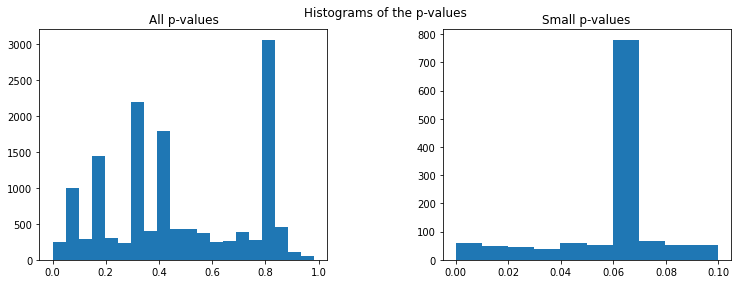

Number of features with this threshold:  108


Classification report: 
               precision    recall  f1-score   support

           0       0.25      0.05      0.08        43
           1       0.00      0.00      0.00        35
           2       0.22      0.08      0.11        66
           3       0.25      0.88      0.39       101
           4       0.17      0.01      0.01       157

    accuracy                           0.24       402
   macro avg       0.18      0.20      0.12       402
weighted avg       0.19      0.24      0.13       402

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(    'global',        'num_subreddit'),
            ('subreddits',      'formerpizzahuts'),
            ('subreddits',           'mbtidating'),
            ('subreddits',              'canning'),
            ('subreddits',           'wahoostipi'),
            ('subreddits',          'drydockporn'),
            ('subreddits',      'firstimpression'),
            ('subreddits',       'larrystylinson'),
            ('subreddits',       'warframerunway'),
            ('subreddits',              'smoking'),
            ('subreddits',                'iasip'),
            ('subreddits',  'newjerseyforsanders'),
            ('subreddits',  'psilocybinmushrooms'),
            ('subreddits',   'wholesomegreentext'),
            ('subreddits',                 'nova'),
            ('subreddits',     'garlicbreadmemes'),
            ('subreddits',                'chuck'),
            ('subreddits',          'cloververse')

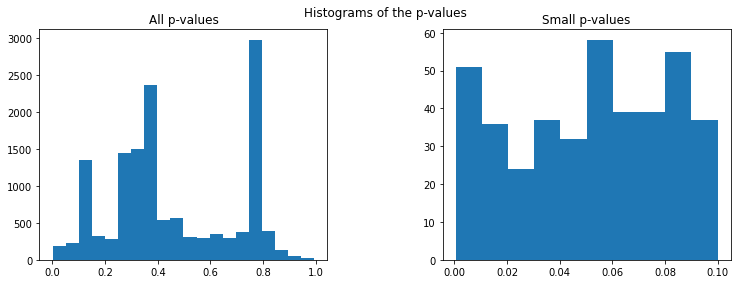

Number of features with this threshold:  277


Classification report: 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25       144
           1       0.20      0.13      0.16        63
           2       0.17      0.12      0.14        80
           3       0.09      0.13      0.11        47
           4       0.18      0.40      0.25        68

    accuracy                           0.20       402
   macro avg       0.19      0.20      0.18       402
weighted avg       0.22      0.20      0.20       402

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',         'startrekgifs'),
            ('subreddits',         'godlesswomen'),
            ('subreddits',                 'arma'),
            ('subreddits',    'shittylegaladvice'),
            ('subreddits',         'garlicmarket'),
            ('subreddits',              'newgirl'),
            ('subreddits',         'elitelavigny'),
            ('subreddits',            'charlotte'),
            ('subreddits',             'birthday'),
            ('subreddits', 'cardsagainsthumanity'),
            ('subreddits',               'fetish'),
            ('subreddits',                 'mepl'),
            ('subreddits',         'christianr4r'),
            ('subreddits',   'completefreespeech'),
            ('subreddits',    'videogameanalysis'),
            ('subreddits',           'howyoudoin'),
            ('subreddits',            'mightyno9'),
            ('subreddits',                 'rift')

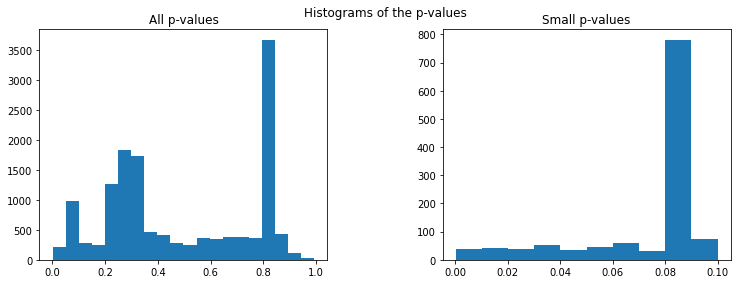

Number of features with this threshold:  205


Classification report: 
               precision    recall  f1-score   support

           0       0.47      0.85      0.60       168
           1       0.13      0.06      0.09        62
           2       0.30      0.08      0.13        73
           3       0.25      0.16      0.19        44
           4       0.26      0.09      0.14        55

    accuracy                           0.41       402
   macro avg       0.28      0.25      0.23       402
weighted avg       0.33      0.41      0.33       402

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',     'transitiongoals'),
            ('subreddits',        'treeofsavior'),
            ('subreddits',        'preformances'),
            ('subreddits',          'papgrappen'),
            ('subreddits',              'ethdev'),
            ('subreddits',        'christianr4r'),
            ('subreddits',           'slackline'),
            ('subreddits',     'eternalcardgame'),
            ('subreddits',            'sitecore'),
            ('subreddits',            'mathrock'),
            ('subreddits',              'seinen'),
            ('subreddits',        'donaldglover'),
            ('subreddits',        'designerreps'),
            ('subreddits',         'u_wootyhoot'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',          'archeology'),
            ('subreddits',          'officehelp'),
            ('subreddits',         'neutralnews'),
            ('su

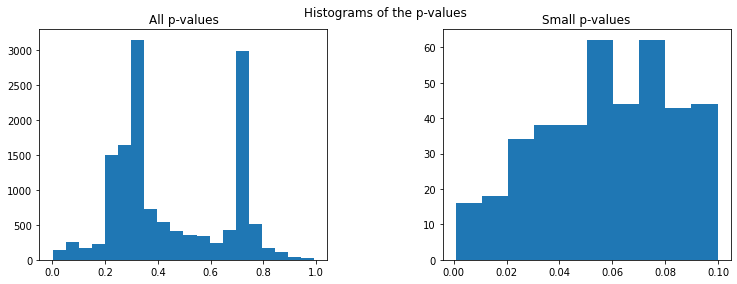

Number of features with this threshold:  104


Classification report: 
               precision    recall  f1-score   support

           0       0.30      0.40      0.34       138
           1       0.18      0.36      0.24        59
           2       0.14      0.03      0.05        69
           3       0.19      0.06      0.09        66
           4       0.20      0.19      0.19        70

    accuracy                           0.24       402
   macro avg       0.20      0.21      0.18       402
weighted avg       0.22      0.24      0.21       402

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([('subreddits',          'vinesauce'),
            ('subreddits',      'canadaclicker'),
            ('subreddits',          'modelcccp'),
            ('subreddits', 'humansbeingfriends'),
            ('subreddits',         'animeitaly'),
            ('subreddits',           'roadporn'),
            ('subreddits',     'massquantities'),
            ('subreddits',          'analytics'),
            ('subreddits',      'shotglassbets'),
            ('subreddits',                'amd'),
            ('subreddits',               'soko'),
            ('subreddits',    'freecompliments'),
            ('subreddits',      'oliverfrancis'),
            ('subreddits',               'yale'),
            ('subreddits',        'tricitieswa'),
            ('subreddits',            'dueling'),
            ('subreddits', 'metacancersubdrama'),
            ('subreddits',              'bacon'),
            ('subreddits',   'imag

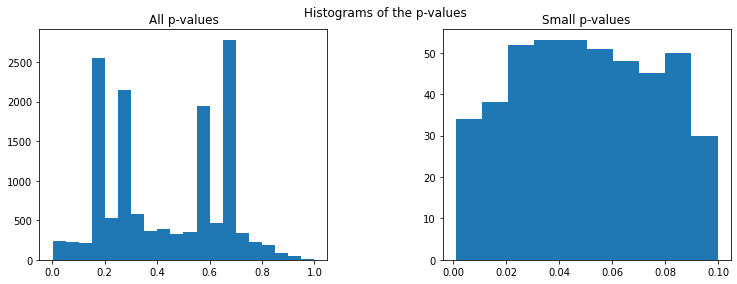

Number of features with this threshold:  174


Classification report: 
               precision    recall  f1-score   support

           0       0.27      0.52      0.36       101
           1       0.17      0.04      0.06        57
           2       0.24      0.05      0.09        75
           3       0.14      0.07      0.09        61
           4       0.30      0.43      0.35       108

    accuracy                           0.27       402
   macro avg       0.22      0.22      0.19       402
weighted avg       0.24      0.27      0.22       402



In [19]:
print("Y has 5 classes: \n")
classify(df, 'multi', plotting=True)

# Results of the train set

In [20]:
def classify_trainset(df, classes, plotting=True):
    for trait_name in traits:
#         num_feat = switching(trait_name)
        num_feat = 30
        print("Trait to predict: ", trait_name)
        if classes == 'binary':
            x,y = trait(df, 'binary',trait_name)
        else:
            x,y = trait(df, 'multi', trait_name)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        print("Number of authors in y_train: ", len(y_train))
        print("Number of authors in y_test: ", len(y_test))
        logpipe = create_pipeline(x_train, y_train, 'log', num_feat)
        y_pred=logpipe.predict(x_train)
        print("Number of authors in y_pred: ", len(y_pred))
        names = get_names(x, logpipe)
        print("Names of the top", len(names), "features: \n", names, "\n")
        pvalues = get_pvalues(logpipe, x)
    #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
        if trait_name=="openness":
            count = pvalues['pvalue'].le(0.02).sum()
        if trait_name=="conscientiousness":
            count = pvalues['pvalue'].le(0.07).sum()
        if trait_name=="extraversion":
            count = pvalues['pvalue'].le(0.05).sum()
        if trait_name=="agreeableness":
            count = pvalues['pvalue'].le(0.04).sum()
        if trait_name=="neuroticism":
            count = pvalues['pvalue'].le(0.04).sum()
        print("Number of features with this threshold: ", count)
#         print("\nP-Values: \nNumber of features: ", 30)
#         print(pvalues.nsmallest(count,'pvalue'))
        print("\n")
        report = scores(y_train, y_pred, "report")
        print("Classification report: \n", report)
        if classes == 'binary':
            cnfmatrix = create_cnfmatrix(y_train, y_pred, plotting=True) 
    #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
    #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
            lr_precision, lr_recall = score_plot(logpipe, y_train, x_train)
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

## Train set: binary outcome

Classify trainset 
Y is binary: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',      'taylorswiftbum'),
            ('subreddits',        'colonizemars'),
            ('subreddits',  'takeonestepforward'),
            ('subreddits',      'incelsgonewild'),
            ('subreddits',           'xsomalian'),
            ('subreddits',     'choose_your_own'),
            ('subreddits',            'calmdown'),
            ('subreddits',         'pharahmains'),
            ('subreddits',            'polyglot'),
            ('subreddits',             'scratch'),
            ('subreddits',              'techno'),
            ('subreddits',       'manyatruenerd'),
            ('subreddits',       'youshouldknow'),
            ('subreddits',          'pussymound'),
            ('subreddits',         'pipetobacco'),
            ('subreddits',    'perfect_response'),
            ('subreddits',                 'npc'),
            ('subreddits',            'winnipeg'),
            ('s

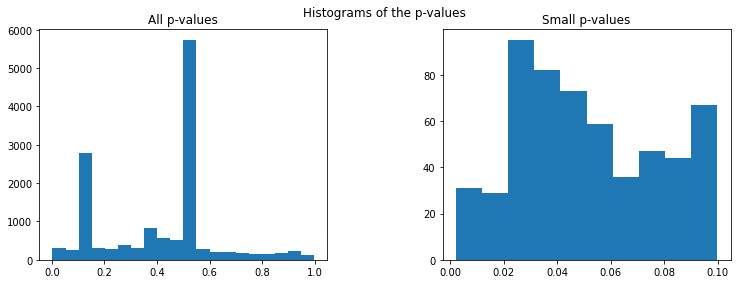

Number of features with this threshold:  54


Classification report: 
               precision    recall  f1-score   support

           0       0.63      0.26      0.37       355
           1       0.75      0.94      0.83       849

    accuracy                           0.74      1204
   macro avg       0.69      0.60      0.60      1204
weighted avg       0.72      0.74      0.70      1204

TN, FP, FN, TP:  93 262 55 794 
Sum:  1204 
Sum correct predictions:  887 Percent:  0.7367109634551495 
Sum wrong predictions:  317 	Percent:  0.2632890365448505 
Sum actual positives:  849 	Percent:  0.7051495016611296 
Sum actual negatives:  355 	Percent:  0.29485049833887045


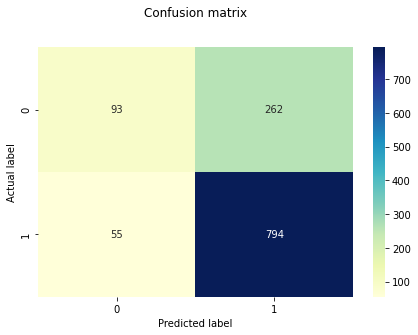

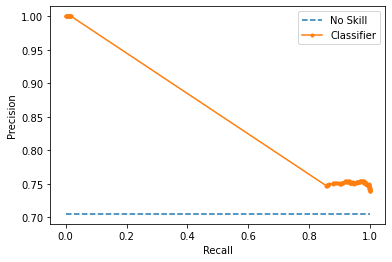

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(      'time',           'friday'),
            (      'time',            'march'),
            (      'time',             'june'),
            (      'time',         'november'),
            (      'time',             '2017'),
            ('subreddits',         'cyberdom'),
            ('subreddits',  'tuckedinkitties'),
            ('subreddits',             'anno'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',              'tfc'),
            ('subreddits',      'bimbofetish'),
            ('subreddits',            'ecchi'),
            ('subreddits',         'roadporn'),
            ('subreddits',        'roastmeta'),
            ('subreddits',       'kansascity'),
            ('subreddits',   'warframerunway'),
            ('subreddits',             'nova'),
            ('subreddits',     'allthingsmlg'),
            ('subreddits',       'floridaman'),
            ('subredd

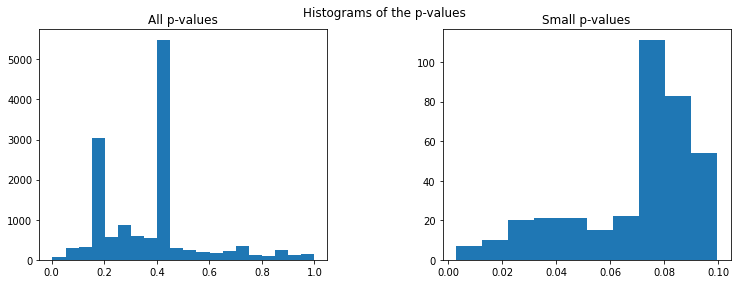

Number of features with this threshold:  115


Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.76      0.72       746
           1       0.53      0.43      0.47       458

    accuracy                           0.64      1204
   macro avg       0.61      0.60      0.60      1204
weighted avg       0.62      0.64      0.63      1204

TN, FP, FN, TP:  568 178 261 197 
Sum:  1204 
Sum correct predictions:  765 Percent:  0.6353820598006644 
Sum wrong predictions:  439 	Percent:  0.3646179401993355 
Sum actual positives:  458 	Percent:  0.3803986710963455 
Sum actual negatives:  746 	Percent:  0.6196013289036545


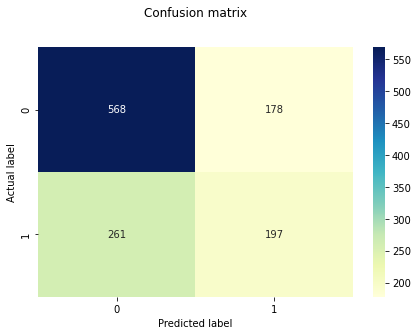

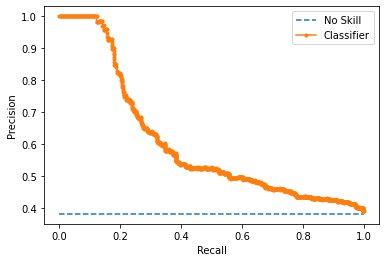

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',             'aram'),
            ('subreddits',       'astro_kpop'),
            ('subreddits',      'politicsnow'),
            ('subreddits',      'goldenkamuy'),
            ('subreddits',  'theexaminedlife'),
            ('subreddits',      '300yearsago'),
            ('subreddits',          'newgirl'),
            ('subreddits',        'stretched'),
            ('subreddits',      'learncsharp'),
            ('subreddits',        'studioone'),
            ('subreddits',        'pokememes'),
            ('subreddits',         'birthday'),
            ('subreddits',   'bigtiddygothgf'),
            ('subreddits',             'mepl'),
            ('subreddits',     'christianr4r'),
            ('subreddits',      'ridiebridie'),
            ('subreddits',          'ableton'),
            ('subreddits',  'oopsdidntmeanto'),
            ('subreddits',            'motog'),
            ('subredd

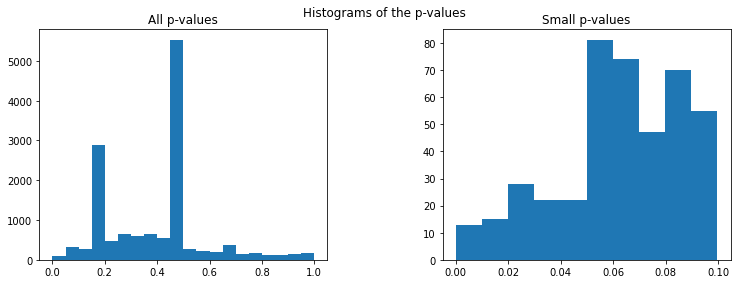

Number of features with this threshold:  101


Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.92      0.81       779
           1       0.69      0.33      0.45       425

    accuracy                           0.71      1204
   macro avg       0.70      0.63      0.63      1204
weighted avg       0.71      0.71      0.68      1204

TN, FP, FN, TP:  716 63 283 142 
Sum:  1204 
Sum correct predictions:  858 Percent:  0.7126245847176079 
Sum wrong predictions:  346 	Percent:  0.287375415282392 
Sum actual positives:  425 	Percent:  0.35299003322259137 
Sum actual negatives:  779 	Percent:  0.6470099667774086


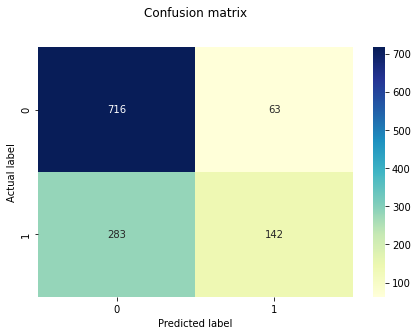

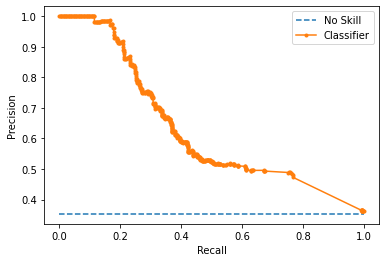

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(    'global',    'controversiality'),
            ('subreddits',                'aram'),
            ('subreddits',        'xntxpolitics'),
            ('subreddits',      'cursedcomments'),
            ('subreddits',       'healthanxiety'),
            ('subreddits',          'brainmemes'),
            ('subreddits',   'legendsoftomorrow'),
            ('subreddits',     'hmusfederalists'),
            ('subreddits',     'mhoclabourpress'),
            ('subreddits',                 'jhu'),
            ('subreddits',        'donaldglover'),
            ('subreddits',           'berlindnd'),
            ('subreddits',                'meup'),
            ('subreddits',     'notthebeaverton'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',                'cern'),
            ('subreddits',            'celebsbr'),
            ('subreddits',                'beer'),
            ('s

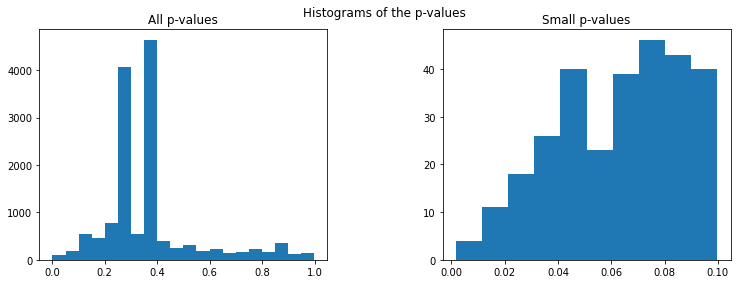

Number of features with this threshold:  53


Classification report: 
               precision    recall  f1-score   support

           0       0.68      0.73      0.70       680
           1       0.61      0.56      0.58       524

    accuracy                           0.65      1204
   macro avg       0.65      0.64      0.64      1204
weighted avg       0.65      0.65      0.65      1204

TN, FP, FN, TP:  495 185 232 292 
Sum:  1204 
Sum correct predictions:  787 Percent:  0.6536544850498339 
Sum wrong predictions:  417 	Percent:  0.34634551495016613 
Sum actual positives:  524 	Percent:  0.43521594684385384 
Sum actual negatives:  680 	Percent:  0.5647840531561462


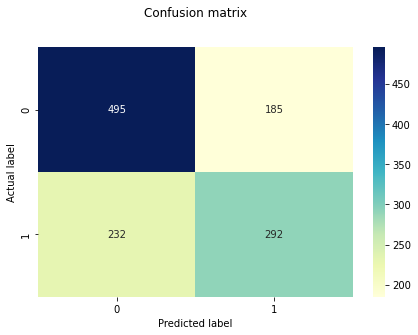

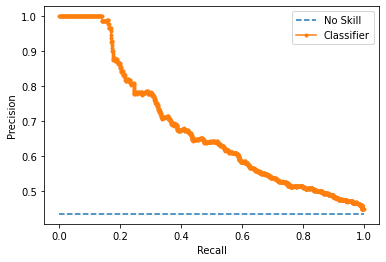

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',             'hammer'),
            ('subreddits',     'onetruetohsaka'),
            ('subreddits',        'rightwinguk'),
            ('subreddits', 'smallpenisproblems'),
            ('subreddits',               '5htp'),
            ('subreddits',            'actuary'),
            ('subreddits',                'g59'),
            ('subreddits',                'dae'),
            ('subreddits',          'intpmusic'),
            ('subreddits',                'm43'),
            ('subreddits',       'thegoodplace'),
            ('subreddits',                'gog'),
            ('subreddits',         'amumumains'),
            ('subreddits',    'mammothmountain'),
            ('subreddits',                'dsp'),
            ('subreddits',            'riseupp'),
            ('subreddits',              'bacon'),
            ('subreddits', 'thegreatwarchannel'),
            ('subreddits',       

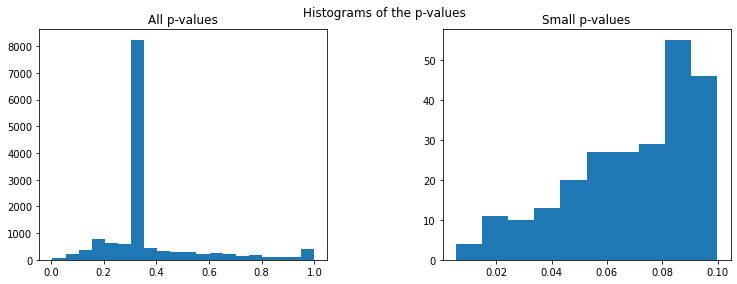

Number of features with this threshold:  31


Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.72      0.65       592
           1       0.65      0.50      0.57       612

    accuracy                           0.61      1204
   macro avg       0.62      0.61      0.61      1204
weighted avg       0.62      0.61      0.61      1204

TN, FP, FN, TP:  429 163 306 306 
Sum:  1204 
Sum correct predictions:  735 Percent:  0.6104651162790697 
Sum wrong predictions:  469 	Percent:  0.38953488372093026 
Sum actual positives:  612 	Percent:  0.5083056478405316 
Sum actual negatives:  592 	Percent:  0.49169435215946844


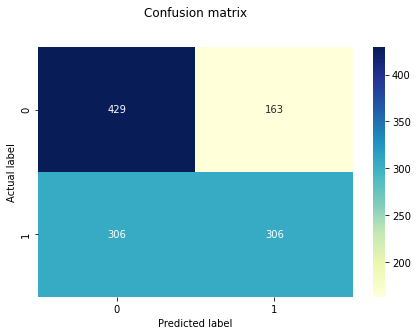

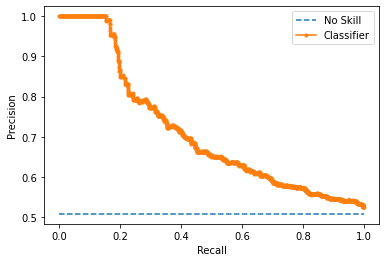

In [21]:
print("Classify trainset \nY is binary: \n")
classify_trainset(df, 'binary', plotting=True)

## Train set: outcome has 5 classes

Classify trainset 
Y has 5 classes: 

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',     'taylorswiftbum'),
            ('subreddits', 'takeonestepforward'),
            ('subreddits',           'carlisle'),
            ('subreddits',     'incelsgonewild'),
            ('subreddits',            'effexor'),
            ('subreddits',            'dessert'),
            ('subreddits', 'swiggityswootygifs'),
            ('subreddits',           'calmdown'),
            ('subreddits',        'kutreclames'),
            ('subreddits',            'scratch'),
            ('subreddits',          'zeldabotw'),
            ('subreddits', 'foundthemobileuser'),
            ('subreddits',          'fuckdruid'),
            ('subreddits',            'corolla'),
            ('subreddits',               'meat'),
            ('subreddits',                'sfx'),
            ('subreddits',              'motog'),
            ('subreddits',       'entrepreneur'),
            ('subreddits',   'yan

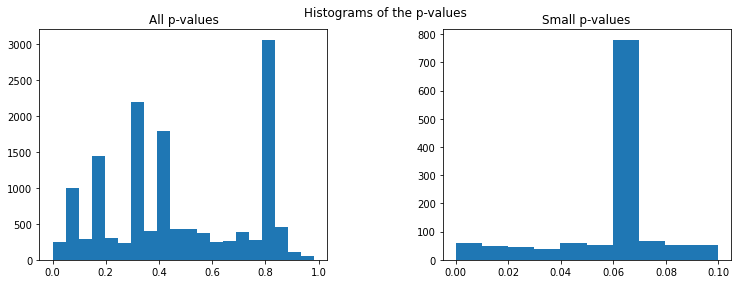

Number of features with this threshold:  108


Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.22      0.33       158
           1       0.69      0.16      0.26       124
           2       0.46      0.14      0.21       205
           3       0.23      0.94      0.36       250
           4       0.38      0.02      0.04       467

    accuracy                           0.27      1204
   macro avg       0.49      0.29      0.24      1204
weighted avg       0.43      0.27      0.20      1204

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(    'global',        'num_subreddit'),
            ('subreddits',      'formerpizzahuts'),
            ('subreddits',           'mbtidating'),
            ('subreddits',              'canning'),
            ('subreddits',           'wahoostipi'),
            ('subreddits',          'drydockporn'),
            ('subreddits',      'firstimpression'),
            ('subreddits',       'larrystylinson'),
            ('subreddits',       'warframerunway'),
            ('subreddits',              'smoking'),
            ('subreddits',                'iasip'),
            ('subreddits',  'newjerseyforsanders'),
            ('subreddits',  'psilocybinmushrooms'),
            ('subreddits',   'wholesomegreentext'),
            ('subreddits',                 'nova'),
            ('subreddits',     'garlicbreadmemes'),
            ('subreddits',                'chuck'),
            ('subreddits',          'cloververse'

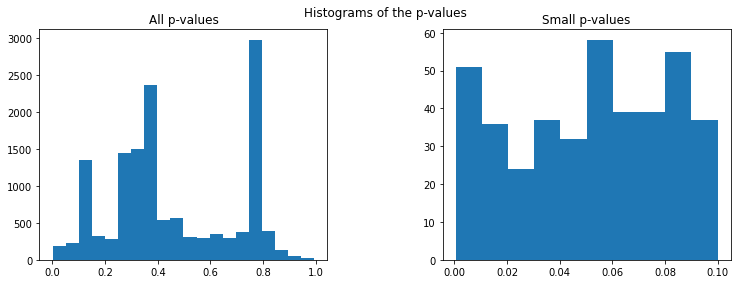

Number of features with this threshold:  277


Classification report: 
               precision    recall  f1-score   support

           0       0.41      0.28      0.33       416
           1       0.36      0.24      0.29       236
           2       0.19      0.17      0.18       196
           3       0.29      0.41      0.34       145
           4       0.23      0.42      0.30       211

    accuracy                           0.29      1204
   macro avg       0.30      0.30      0.29      1204
weighted avg       0.32      0.29      0.29      1204

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',         'startrekgifs'),
            ('subreddits',         'godlesswomen'),
            ('subreddits',                 'arma'),
            ('subreddits',    'shittylegaladvice'),
            ('subreddits',         'garlicmarket'),
            ('subreddits',              'newgirl'),
            ('subreddits',         'elitelavigny'),
            ('subreddits',            'charlotte'),
            ('subreddits',             'birthday'),
            ('subreddits', 'cardsagainsthumanity'),
            ('subreddits',               'fetish'),
            ('subreddits',                 'mepl'),
            ('subreddits',         'christianr4r'),
            ('subreddits',   'completefreespeech'),
            ('subreddits',    'videogameanalysis'),
            ('subreddits',           'howyoudoin'),
            ('subreddits',            'mightyno9'),
            ('subreddits',                 'rift'

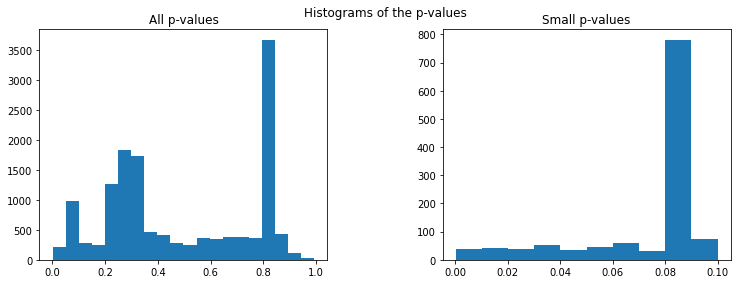

Number of features with this threshold:  205


Classification report: 
               precision    recall  f1-score   support

           0       0.46      0.85      0.59       477
           1       0.26      0.12      0.16       219
           2       0.44      0.19      0.26       193
           3       0.56      0.25      0.35       132
           4       0.38      0.15      0.22       183

    accuracy                           0.44      1204
   macro avg       0.42      0.31      0.32      1204
weighted avg       0.42      0.44      0.38      1204

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',     'transitiongoals'),
            ('subreddits',        'treeofsavior'),
            ('subreddits',        'preformances'),
            ('subreddits',          'papgrappen'),
            ('subreddits',              'ethdev'),
            ('subreddits',        'christianr4r'),
            ('subreddits',           'slackline'),
            ('subreddits',     'eternalcardgame'),
            ('subreddits',            'sitecore'),
            ('subreddits',            'mathrock'),
            ('subreddits',              'seinen'),
            ('subreddits',        'donaldglover'),
            ('subreddits',        'designerreps'),
            ('subreddits',         'u_wootyhoot'),
            ('subreddits',     'ironfistnetflix'),
            ('subreddits',          'archeology'),
            ('subreddits',          'officehelp'),
            ('subreddits',         'neutralnews'),
            ('s

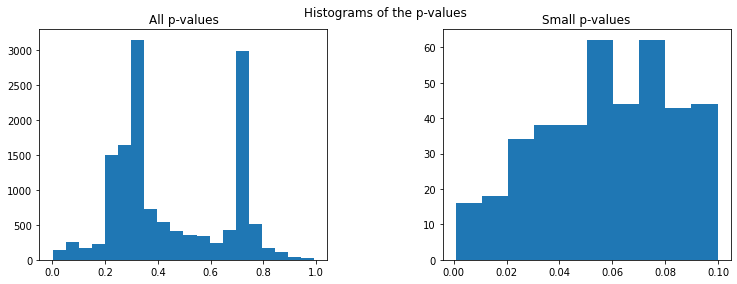

Number of features with this threshold:  104


Classification report: 
               precision    recall  f1-score   support

           0       0.38      0.48      0.43       394
           1       0.23      0.44      0.30       211
           2       0.55      0.12      0.19       204
           3       0.52      0.22      0.31       181
           4       0.33      0.27      0.30       214

    accuracy                           0.34      1204
   macro avg       0.40      0.31      0.31      1204
weighted avg       0.39      0.34      0.32      1204

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([('subreddits',          'vinesauce'),
            ('subreddits',      'canadaclicker'),
            ('subreddits',          'modelcccp'),
            ('subreddits', 'humansbeingfriends'),
            ('subreddits',         'animeitaly'),
            ('subreddits',           'roadporn'),
            ('subreddits',     'massquantities'),
            ('subreddits',          'analytics'),
            ('subreddits',      'shotglassbets'),
            ('subreddits',                'amd'),
            ('subreddits',               'soko'),
            ('subreddits',    'freecompliments'),
            ('subreddits',      'oliverfrancis'),
            ('subreddits',               'yale'),
            ('subreddits',        'tricitieswa'),
            ('subreddits',            'dueling'),
            ('subreddits', 'metacancersubdrama'),
            ('subreddits',              'bacon'),
            ('subreddits',   'ima

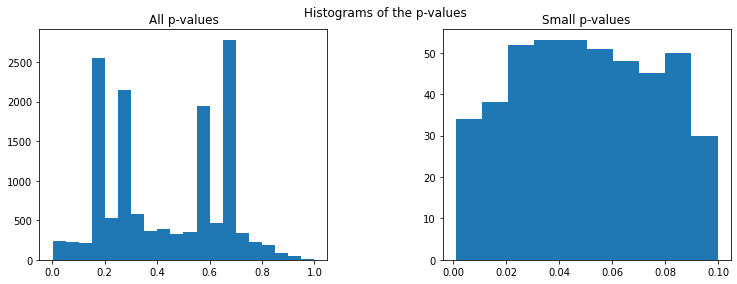

Number of features with this threshold:  174


Classification report: 
               precision    recall  f1-score   support

           0       0.32      0.59      0.42       317
           1       0.39      0.10      0.17       172
           2       0.49      0.17      0.25       198
           3       0.51      0.21      0.30       169
           4       0.38      0.49      0.43       348

    accuracy                           0.37      1204
   macro avg       0.42      0.31      0.31      1204
weighted avg       0.40      0.37      0.34      1204



In [22]:
print("Classify trainset \nY has 5 classes: \n")
classify_trainset(df, 'multi', plotting=True)

# Results without predictor subreddit

## Testset: binary

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global',          'gilded'),
            (        'global',            'lang'),
            (          'time',          'monday'),
            (          'time',         'tuesday'),
            (          'time',       'wednesday'),
            (          'time',        'thursday'),
            (          'time',          'friday'),
            (          'time',        'saturday'),
            (          'time',         'january'),
            (          'time',           'april'),
            (          'time',             'may'),
            (          'time',            'june'),
            (          'time',            'juli'),
            (          'time',          'august'),
            (          'time',       'september'),
            (          'time',         'october'),
            (          'time',        'december'),
            (          'time',            '2015'),
            (   

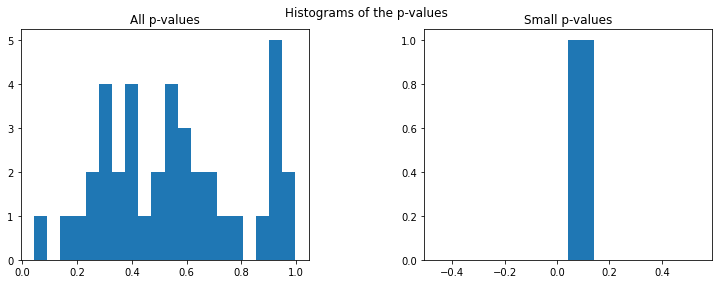

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.29      0.61      0.39       105
           1       0.77      0.47      0.58       297

    accuracy                           0.50       402
   macro avg       0.53      0.54      0.49       402
weighted avg       0.65      0.50      0.53       402

TN, FP, FN, TP:  64 41 158 139 
Sum:  402 
Sum correct predictions:  203 Percent:  0.5049751243781094 
Sum wrong predictions:  199 	Percent:  0.49502487562189057 
Sum actual positives:  297 	Percent:  0.7388059701492538 
Sum actual negatives:  105 	Percent:  0.26119402985074625


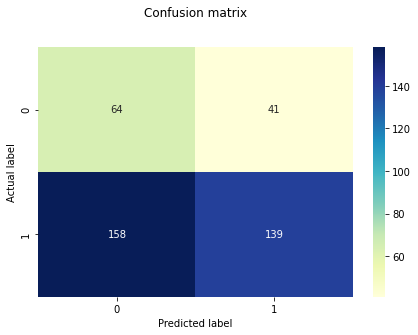

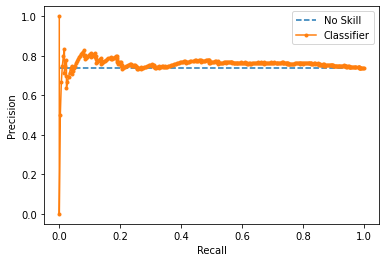

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'num_subreddit'),
            (        'global',          'lang'),
            (          'time',        'monday'),
            (          'time',       'tuesday'),
            (          'time',     'wednesday'),
            (          'time',      'thursday'),
            (          'time',        'friday'),
            (          'time',      'saturday'),
            (          'time',        'sunday'),
            (          'time',       'january'),
            (          'time',      'february'),
            (          'time',         'march'),
            (          'time',         'april'),
            (          'time',           'may'),
            (          'time',          'june'),
            (          'time',          'juli'),
            (          'time',        'august'),
            (          'time',     'september'),
            (          'time',       'october'),
   

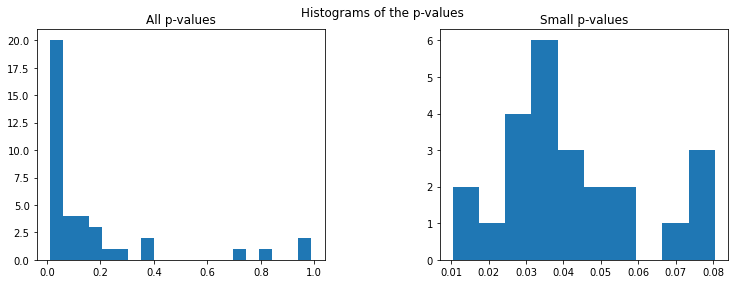

Number of features with this threshold:  20


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.44      0.52       251
           1       0.39      0.61      0.48       151

    accuracy                           0.50       402
   macro avg       0.52      0.52      0.50       402
weighted avg       0.55      0.50      0.51       402

TN, FP, FN, TP:  110 141 59 92 
Sum:  402 
Sum correct predictions:  202 Percent:  0.5024875621890548 
Sum wrong predictions:  200 	Percent:  0.4975124378109453 
Sum actual positives:  151 	Percent:  0.3756218905472637 
Sum actual negatives:  251 	Percent:  0.6243781094527363


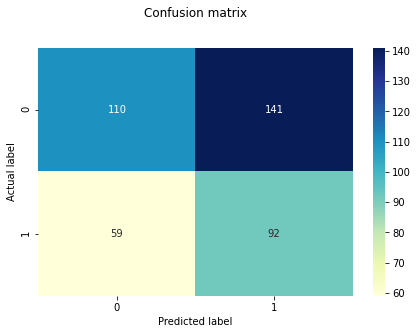

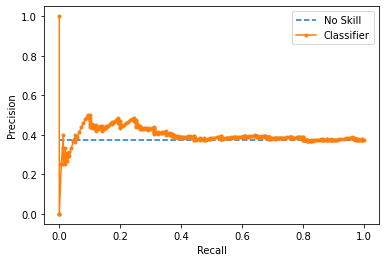

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',          'tuesday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'april'),
            (          'time',             'june'),
            (          'time',           'august'),
            (          'time',        'september'),
            (          'time',          'october'),
            (          'time',         'november'),
            (          'time',         'december'),
            (          'time',             '2017')

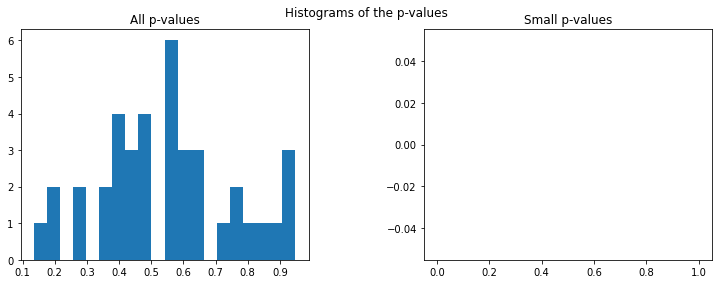

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.52      0.58       258
           1       0.37      0.50      0.42       144

    accuracy                           0.51       402
   macro avg       0.51      0.51      0.50       402
weighted avg       0.55      0.51      0.52       402

TN, FP, FN, TP:  134 124 72 72 
Sum:  402 
Sum correct predictions:  206 Percent:  0.5124378109452736 
Sum wrong predictions:  196 	Percent:  0.48756218905472637 
Sum actual positives:  144 	Percent:  0.3582089552238806 
Sum actual negatives:  258 	Percent:  0.6417910447761194


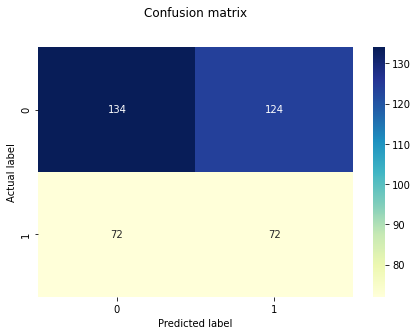

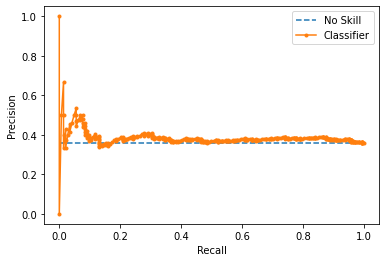

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',        'september'),
            (          'time',          'october'),
            (          'time',         'november'),
            (          'time',         'december')

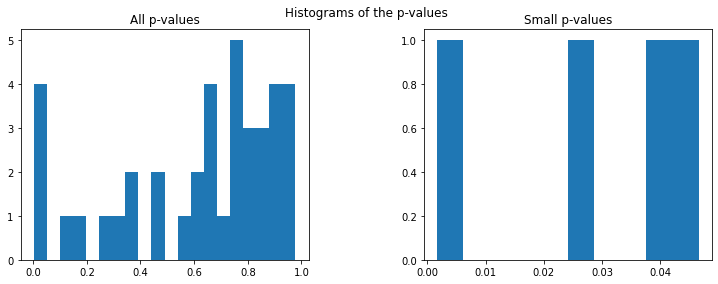

Number of features with this threshold:  3


Classification report: 
               precision    recall  f1-score   support

           0       0.61      0.50      0.55       225
           1       0.48      0.59      0.53       177

    accuracy                           0.54       402
   macro avg       0.55      0.55      0.54       402
weighted avg       0.55      0.54      0.54       402

TN, FP, FN, TP:  113 112 72 105 
Sum:  402 
Sum correct predictions:  218 Percent:  0.5422885572139303 
Sum wrong predictions:  184 	Percent:  0.4577114427860697 
Sum actual positives:  177 	Percent:  0.44029850746268656 
Sum actual negatives:  225 	Percent:  0.5597014925373134


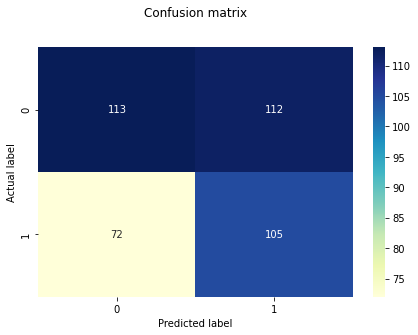

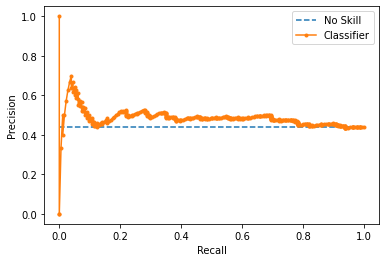

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',              'may'),
            (          'time',             'june'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',          'october'),
            (          'time',         'december'),
            (          'time',             '2015'),
            (          'time',             '2017'),
            (          'time',             '2018')

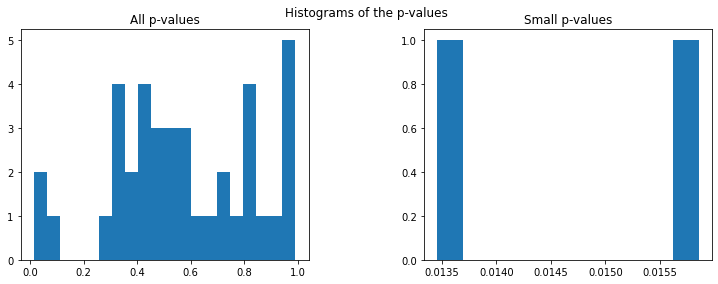

Number of features with this threshold:  2


Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.56      0.56       201
           1       0.56      0.56      0.56       201

    accuracy                           0.56       402
   macro avg       0.56      0.56      0.56       402
weighted avg       0.56      0.56      0.56       402

TN, FP, FN, TP:  112 89 89 112 
Sum:  402 
Sum correct predictions:  224 Percent:  0.5572139303482587 
Sum wrong predictions:  178 	Percent:  0.4427860696517413 
Sum actual positives:  201 	Percent:  0.5 
Sum actual negatives:  201 	Percent:  0.5


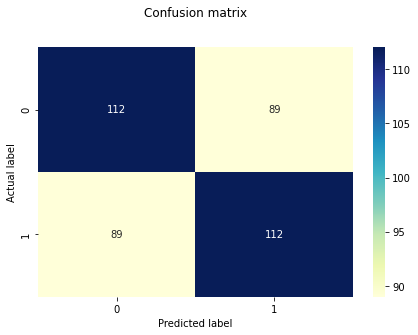

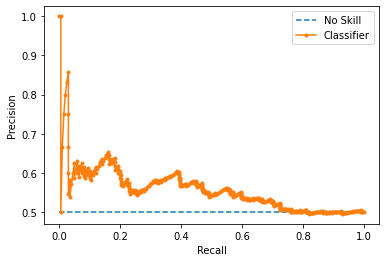

In [23]:
classify(smalldf, 'binary', plotting=True)

## Testset: multi

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global',          'gilded'),
            (        'global',   'num_subreddit'),
            (        'global',            'lang'),
            (          'time',          'monday'),
            (          'time',         'tuesday'),
            (          'time',       'wednesday'),
            (          'time',        'thursday'),
            (          'time',          'friday'),
            (          'time',        'saturday'),
            (          'time',          'sunday'),
            (          'time',         'january'),
            (          'time',        'february'),
            (          'time',           'march'),
            (          'time',           'april'),
            (          'time',             'may'),
            (          'time',            'june'),
            (          'time',            'juli'),
            (          'time',          'august'),
            (   

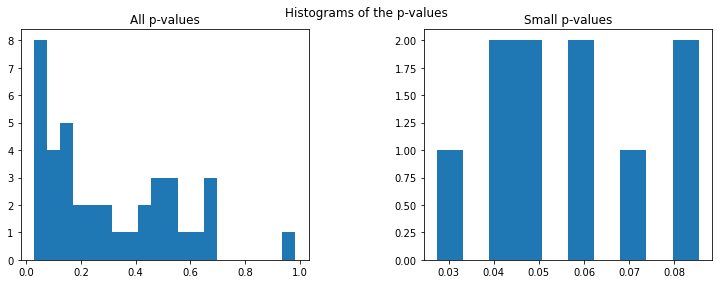

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.14      0.26      0.18        43
           1       0.08      0.31      0.13        35
           2       0.17      0.15      0.16        66
           3       0.30      0.24      0.27       101
           4       0.43      0.13      0.20       157

    accuracy                           0.19       402
   macro avg       0.22      0.22      0.19       402
weighted avg       0.29      0.19      0.20       402

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global',  'num_subreddit'),
            (        'global',           'lang'),
            (          'time',         'monday'),
            (          'time',      'wednesday'),
            (          'time',       'thursday'),
            (          'time',         'friday'),
            (          'time',       'saturday'),
            (          'time',         'sunday'),
            (          'time',          'march'),
            (          'time',          'april'),
            (          'time',            'may'),
            (          'time',           'june'),
            (          'time',           'juli'),
            (          'time',         'august'),
            (          'time',      'september'),
            (          'time',        'october'),
            (          'time',       'november'),
            (          'time',       'december'),
            (          'time',    

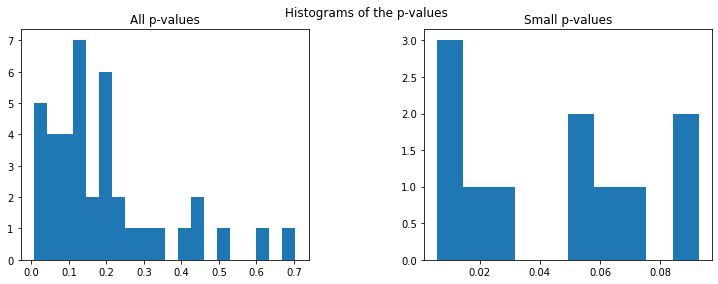

Number of features with this threshold:  9


Classification report: 
               precision    recall  f1-score   support

           0       0.38      0.19      0.26       144
           1       0.10      0.10      0.10        63
           2       0.18      0.25      0.21        80
           3       0.14      0.23      0.18        47
           4       0.25      0.29      0.27        68

    accuracy                           0.21       402
   macro avg       0.21      0.21      0.20       402
weighted avg       0.25      0.21      0.22       402

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global',           'lang'),
            (          'time',         'monday'),
            (          'time',      'wednesday'),
            (          'time',       'thursday'),
            (          'time',         'friday'),
            (          'time',       'saturday'),
            (          'time',         'sunday'),
            (          'time',        'january'),
            (          'time',       'february'),
            (          'time',          'march'),
            (          'time',          'april'),
            (          'time',            'may'),
            (          'time',           'june'),
            (          'time',           'juli'),
            (          'time',         'august'),
            (          'time',      'september'),
            (          'time',        'october'),
            (          'time',           '2016'),
            (          'time',    

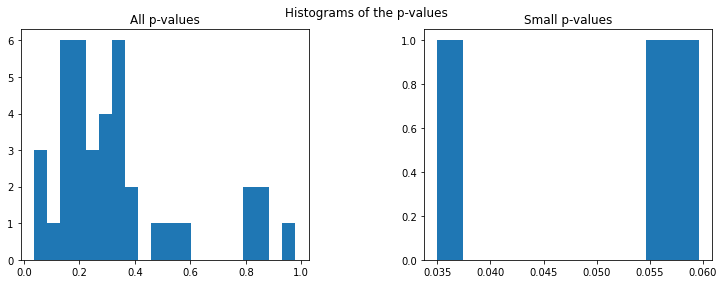

Number of features with this threshold:  1


Classification report: 
               precision    recall  f1-score   support

           0       0.45      0.23      0.31       168
           1       0.13      0.13      0.13        62
           2       0.17      0.21      0.19        73
           3       0.07      0.09      0.08        44
           4       0.12      0.24      0.16        55

    accuracy                           0.20       402
   macro avg       0.19      0.18      0.17       402
weighted avg       0.26      0.20      0.21       402

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'march'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'juli'),
            (          'time',             '2015')

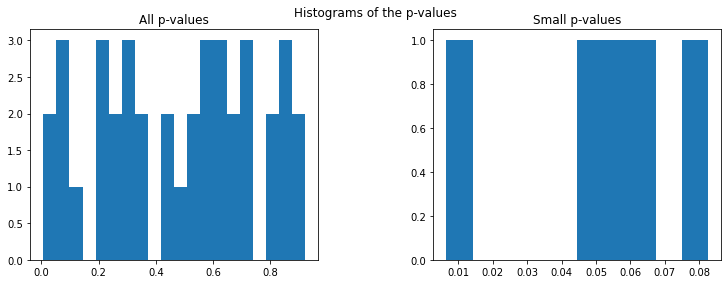

Number of features with this threshold:  1


Classification report: 
               precision    recall  f1-score   support

           0       0.42      0.17      0.25       138
           1       0.16      0.27      0.20        59
           2       0.16      0.16      0.16        69
           3       0.19      0.32      0.24        66
           4       0.19      0.17      0.18        70

    accuracy                           0.21       402
   macro avg       0.22      0.22      0.20       402
weighted avg       0.26      0.21      0.21       402

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'march'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'june'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',          'october')

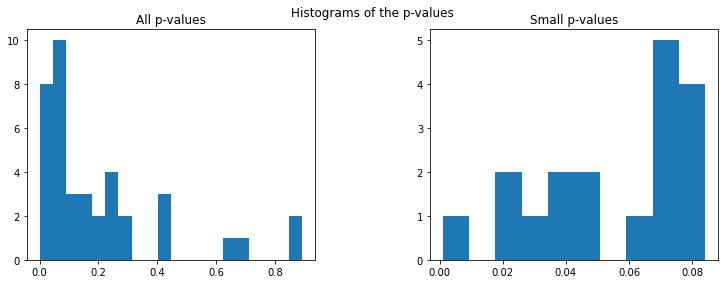

Number of features with this threshold:  5


Classification report: 
               precision    recall  f1-score   support

           0       0.29      0.30      0.30       101
           1       0.17      0.30      0.22        57
           2       0.24      0.15      0.18        75
           3       0.14      0.15      0.15        61
           4       0.32      0.28      0.30       108

    accuracy                           0.24       402
   macro avg       0.23      0.23      0.23       402
weighted avg       0.25      0.24      0.24       402



In [24]:
classify(smalldf, 'multi', plotting=True)

## Trainset: binary

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global',          'gilded'),
            (        'global',            'lang'),
            (          'time',          'monday'),
            (          'time',         'tuesday'),
            (          'time',       'wednesday'),
            (          'time',        'thursday'),
            (          'time',          'friday'),
            (          'time',        'saturday'),
            (          'time',         'january'),
            (          'time',           'april'),
            (          'time',             'may'),
            (          'time',            'june'),
            (          'time',            'juli'),
            (          'time',          'august'),
            (          'time',       'september'),
            (          'time',         'october'),
            (          'time',        'december'),
            (          'time',            '2015'),
            (  

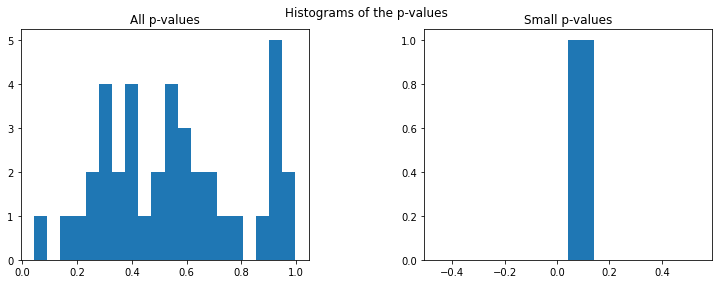

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.35      0.64      0.45       355
           1       0.77      0.49      0.60       849

    accuracy                           0.54      1204
   macro avg       0.56      0.57      0.53      1204
weighted avg       0.64      0.54      0.56      1204

TN, FP, FN, TP:  228 127 430 419 
Sum:  1204 
Sum correct predictions:  647 Percent:  0.5373754152823921 
Sum wrong predictions:  557 	Percent:  0.462624584717608 
Sum actual positives:  849 	Percent:  0.7051495016611296 
Sum actual negatives:  355 	Percent:  0.29485049833887045


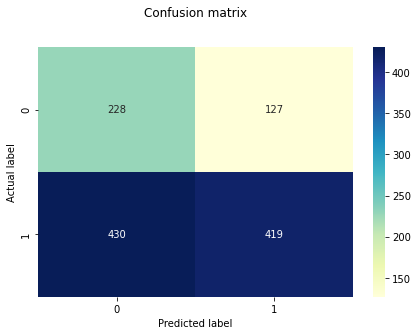

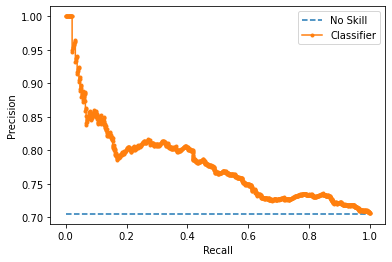

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'num_subreddit'),
            (        'global',          'lang'),
            (          'time',        'monday'),
            (          'time',       'tuesday'),
            (          'time',     'wednesday'),
            (          'time',      'thursday'),
            (          'time',        'friday'),
            (          'time',      'saturday'),
            (          'time',        'sunday'),
            (          'time',       'january'),
            (          'time',      'february'),
            (          'time',         'march'),
            (          'time',         'april'),
            (          'time',           'may'),
            (          'time',          'june'),
            (          'time',          'juli'),
            (          'time',        'august'),
            (          'time',     'september'),
            (          'time',       'october'),
  

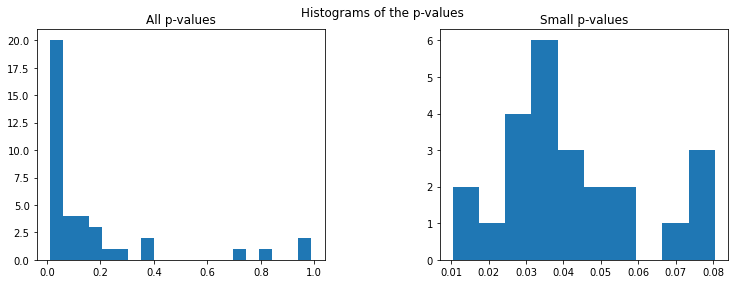

Number of features with this threshold:  20


Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.51      0.58       746
           1       0.44      0.62      0.51       458

    accuracy                           0.55      1204
   macro avg       0.56      0.57      0.55      1204
weighted avg       0.59      0.55      0.56      1204

TN, FP, FN, TP:  379 367 172 286 
Sum:  1204 
Sum correct predictions:  665 Percent:  0.5523255813953488 
Sum wrong predictions:  539 	Percent:  0.4476744186046512 
Sum actual positives:  458 	Percent:  0.3803986710963455 
Sum actual negatives:  746 	Percent:  0.6196013289036545


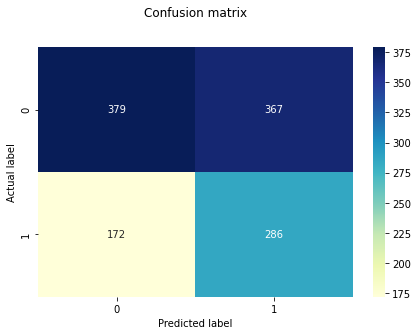

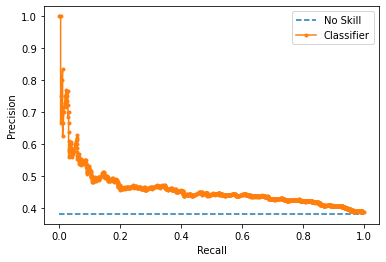

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',          'tuesday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'april'),
            (          'time',             'june'),
            (          'time',           'august'),
            (          'time',        'september'),
            (          'time',          'october'),
            (          'time',         'november'),
            (          'time',         'december'),
            (          'time',             '2017'

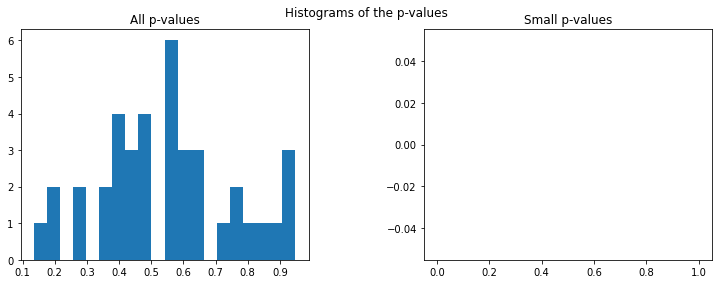

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.58      0.63       779
           1       0.41      0.55      0.47       425

    accuracy                           0.57      1204
   macro avg       0.56      0.56      0.55      1204
weighted avg       0.60      0.57      0.58      1204

TN, FP, FN, TP:  449 330 191 234 
Sum:  1204 
Sum correct predictions:  683 Percent:  0.5672757475083057 
Sum wrong predictions:  521 	Percent:  0.43272425249169433 
Sum actual positives:  425 	Percent:  0.35299003322259137 
Sum actual negatives:  779 	Percent:  0.6470099667774086


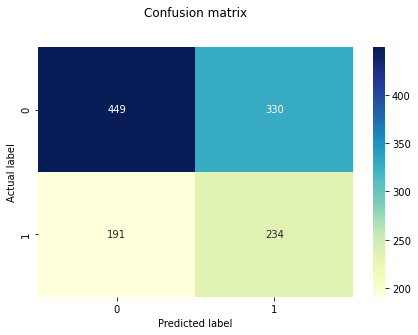

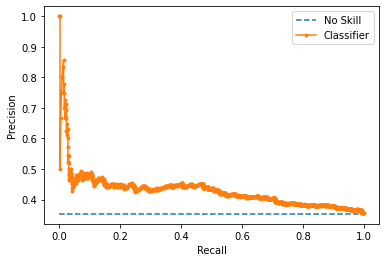

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',        'september'),
            (          'time',          'october'),
            (          'time',         'november'),
            (          'time',         'december'

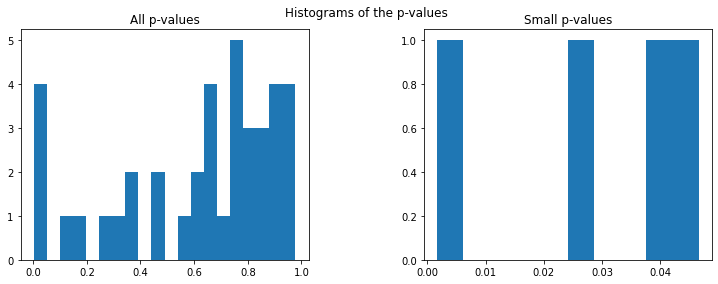

Number of features with this threshold:  3


Classification report: 
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       680
           1       0.51      0.62      0.56       524

    accuracy                           0.58      1204
   macro avg       0.58      0.58      0.58      1204
weighted avg       0.59      0.58      0.58      1204

TN, FP, FN, TP:  370 310 197 327 
Sum:  1204 
Sum correct predictions:  697 Percent:  0.5789036544850499 
Sum wrong predictions:  507 	Percent:  0.4210963455149502 
Sum actual positives:  524 	Percent:  0.43521594684385384 
Sum actual negatives:  680 	Percent:  0.5647840531561462


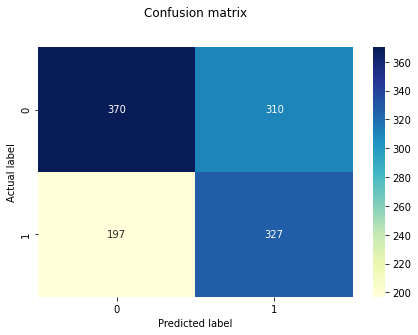

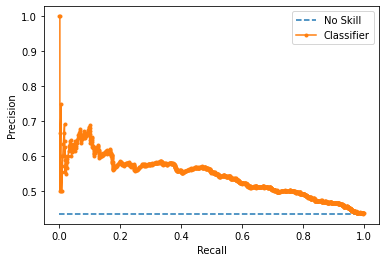

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',              'may'),
            (          'time',             'june'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',          'october'),
            (          'time',         'december'),
            (          'time',             '2015'),
            (          'time',             '2017'),
            (          'time',             '2018'

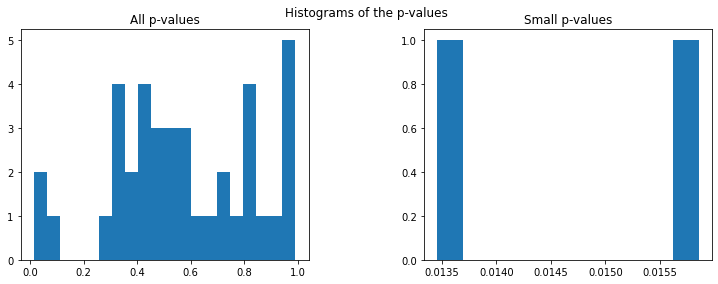

Number of features with this threshold:  2


Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       592
           1       0.61      0.57      0.59       612

    accuracy                           0.59      1204
   macro avg       0.59      0.59      0.59      1204
weighted avg       0.59      0.59      0.59      1204

TN, FP, FN, TP:  368 224 265 347 
Sum:  1204 
Sum correct predictions:  715 Percent:  0.5938538205980066 
Sum wrong predictions:  489 	Percent:  0.4061461794019934 
Sum actual positives:  612 	Percent:  0.5083056478405316 
Sum actual negatives:  592 	Percent:  0.49169435215946844


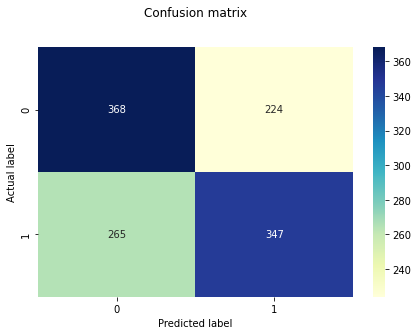

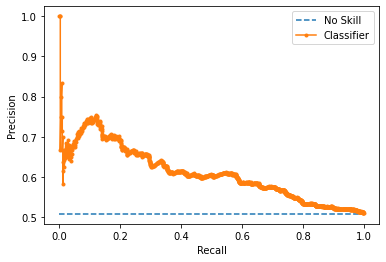

In [25]:
classify_trainset(smalldf, 'binary', plotting=True)

## Trainset: multi

Trait to predict:  openness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global',          'gilded'),
            (        'global',   'num_subreddit'),
            (        'global',            'lang'),
            (          'time',          'monday'),
            (          'time',         'tuesday'),
            (          'time',       'wednesday'),
            (          'time',        'thursday'),
            (          'time',          'friday'),
            (          'time',        'saturday'),
            (          'time',          'sunday'),
            (          'time',         'january'),
            (          'time',        'february'),
            (          'time',           'march'),
            (          'time',           'april'),
            (          'time',             'may'),
            (          'time',            'june'),
            (          'time',            'juli'),
            (          'time',          'august'),
            (  

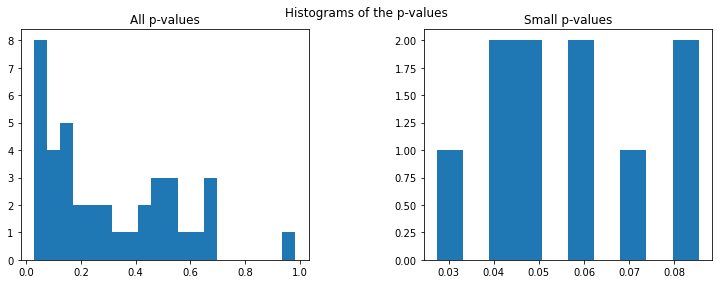

Number of features with this threshold:  0


Classification report: 
               precision    recall  f1-score   support

           0       0.22      0.28      0.24       158
           1       0.15      0.52      0.23       124
           2       0.27      0.26      0.27       205
           3       0.31      0.28      0.30       250
           4       0.57      0.16      0.25       467

    accuracy                           0.26      1204
   macro avg       0.30      0.30      0.26      1204
weighted avg       0.38      0.26      0.26      1204

Trait to predict:  conscientiousness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global',  'num_subreddit'),
            (        'global',           'lang'),
            (          'time',         'monday'),
            (          'time',      'wednesday'),
            (          'time',       'thursday'),
            (          'time',         'friday'),
            (          'time',       'saturday'),
            (          'time',         'sunday'),
            (          'time',          'march'),
            (          'time',          'april'),
            (          'time',            'may'),
            (          'time',           'june'),
            (          'time',           'juli'),
            (          'time',         'august'),
            (          'time',      'september'),
            (          'time',        'october'),
            (          'time',       'november'),
            (          'time',       'december'),
            (          'time',   

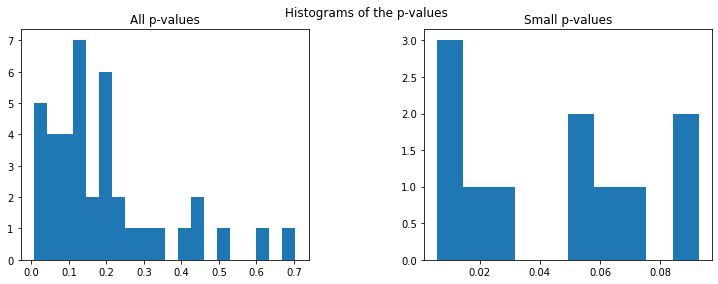

Number of features with this threshold:  9


Classification report: 
               precision    recall  f1-score   support

           0       0.44      0.24      0.31       416
           1       0.35      0.31      0.33       236
           2       0.24      0.36      0.29       196
           3       0.23      0.34      0.28       145
           4       0.26      0.31      0.28       211

    accuracy                           0.30      1204
   macro avg       0.30      0.31      0.30      1204
weighted avg       0.33      0.30      0.30      1204

Trait to predict:  extraversion
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global',           'lang'),
            (          'time',         'monday'),
            (          'time',      'wednesday'),
            (          'time',       'thursday'),
            (          'time',         'friday'),
            (          'time',       'saturday'),
            (          'time',         'sunday'),
            (          'time',        'january'),
            (          'time',       'february'),
            (          'time',          'march'),
            (          'time',          'april'),
            (          'time',            'may'),
            (          'time',           'june'),
            (          'time',           'juli'),
            (          'time',         'august'),
            (          'time',      'september'),
            (          'time',        'october'),
            (          'time',           '2016'),
            (          'time',   

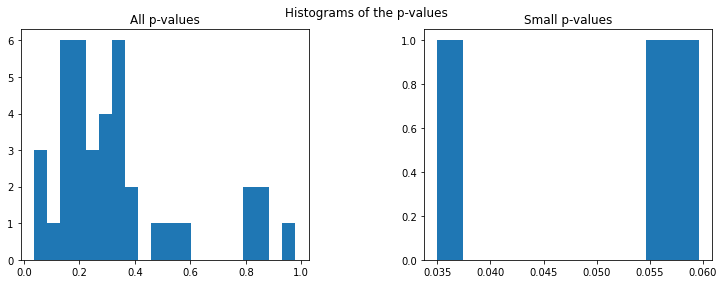

Number of features with this threshold:  1


Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.24      0.33       477
           1       0.23      0.26      0.24       219
           2       0.28      0.30      0.29       193
           3       0.15      0.23      0.18       132
           4       0.22      0.39      0.28       183

    accuracy                           0.27      1204
   macro avg       0.28      0.28      0.26      1204
weighted avg       0.34      0.27      0.28      1204

Trait to predict:  agreeableness
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',           'gilded'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',          'tuesday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'march'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'juli'),
            (          'time',             '2015'

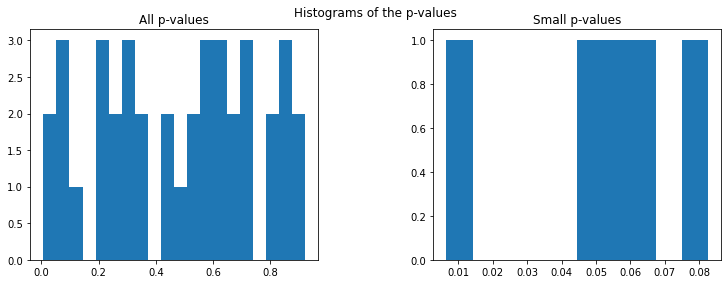

Number of features with this threshold:  1


Classification report: 
               precision    recall  f1-score   support

           0       0.42      0.19      0.26       394
           1       0.26      0.38      0.31       211
           2       0.25      0.26      0.26       204
           3       0.21      0.31      0.25       181
           4       0.27      0.29      0.28       214

    accuracy                           0.27      1204
   macro avg       0.28      0.29      0.27      1204
weighted avg       0.30      0.27      0.27      1204

Trait to predict:  neuroticism
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 MultiIndex([(        'global', 'controversiality'),
            (        'global',    'num_subreddit'),
            (        'global',             'lang'),
            (          'time',           'monday'),
            (          'time',        'wednesday'),
            (          'time',         'thursday'),
            (          'time',           'friday'),
            (          'time',         'saturday'),
            (          'time',           'sunday'),
            (          'time',          'january'),
            (          'time',         'february'),
            (          'time',            'march'),
            (          'time',            'april'),
            (          'time',              'may'),
            (          'time',             'june'),
            (          'time',             'juli'),
            (          'time',           'august'),
            (          'time',          'october'

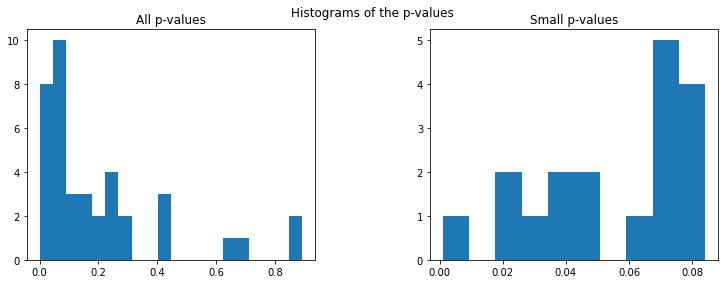

Number of features with this threshold:  5


Classification report: 
               precision    recall  f1-score   support

           0       0.38      0.41      0.40       317
           1       0.23      0.42      0.30       172
           2       0.26      0.17      0.20       198
           3       0.23      0.25      0.24       169
           4       0.38      0.27      0.31       348

    accuracy                           0.31      1204
   macro avg       0.30      0.30      0.29      1204
weighted avg       0.32      0.31      0.30      1204



In [26]:
classify_trainset(smalldf, 'multi', plotting=True)